In [84]:
using JuMP, Gurobi
solver = optimizer_with_attributes(() -> Gurobi.Optimizer(), "OutputFlag" => 0, "Method" => 0)



MathOptInterface.OptimizerWithAttributes(var"#149#150"(), Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("OutputFlag") => 0, MathOptInterface.RawOptimizerAttribute("Method") => 0])

In [85]:
using JuMP,Gurobi ,GLPK, JSON,Pkg , Gurobi
model = Model(GLPK.Optimizer)
dict = Dict()
dict = JSON.parsefile("small.json")


println("---weight--")
println(dict["weight"]["1"])
println("---From--")
println(dict["From"]["1"])
println("---To--")
println(dict["To"]["1"])
println(dict["t"])



---weight--
Dict{String, Any}("4" => 10, "2" => 1, "3" => 5)
---From--
Any["2", "3", "4"]
---To--
Any[]
10


In [86]:
size = length(dict["weight"])
matrix = zeros(size , size)
matrix[3,3]=6
print(size)
for i in dict["N"]
    #display(dict["weight"][i])
end

10

In [87]:


#set_optimizer_attribute(model, "Presolve", 0)
#set_optimizer_attribute(model, "Heuristics",0)
#set_optimizer_attribute(model, "Cuts", 0)
size = length(dict["N"])
matrix = zeros(Int64,size , size)
b=zeros(size)

#print("\n")
b[parse(Int,dict["s"])] = 1
b[parse(Int,dict["t"])] = -1

#print(matrix[10,:])

for i in dict["N"]
    from = dict["From"][i]
    to = dict["To"][i]
    for j in from
        matrix[(parse(Int64,i)),parse(Int64,j)]=dict["weight"][i][j]
    end
end
display(matrix)

10×10 Matrix{Int64}:
 0  1  5  10  0  0  0  0  0   0
 0  0  1   0  0  0  0  0  0   0
 0  0  0   0  0  0  1  0  0   0
 0  0  0   0  0  1  5  0  0   0
 0  0  1   0  0  0  0  6  0   0
 0  0  0   0  1  0  0  0  0  10
 0  0  0   0  0  0  0  0  1   0
 0  0  0   0  0  0  0  0  0   2
 0  0  0   0  0  0  0  1  0   5
 0  0  0   0  0  0  0  0  0   0

In [90]:


n = size
a = zero(rand(n))

function create_master(model::Model)
    @variable(model, x[1:n, 1:n], Bin)
    
    a[1] = 1
    a[n] = -1
    for i in 1:size 
        for j in 1:size
            if matrix[i,j] == 0
                @constraint(model,x[i,j] == 0)
            end
        end
    end

    @constraint(model,[i=1:n],sum(x[i,j] -x[j,i] for j in 1:n) == a[i])
    
    @constraint(model,[i=1:n],sum(x[i,j] for j in 1:n) <= 1)
    
    @objective(model, Min, sum(sum( matrix[i,j] * x[i,j] for j in 1:n) for i in 1:n) ) #l'erreur dient d'ici
    
    
end

create_master (generic function with 1 method)

In [129]:
# empty model
master_model = Model(solver)

# empty model is initialized
create_master(master_model)

optimize!(master_model)
q = value.(master_model[:x])
print(q)
#print(master_model)
solution_summary(master_model)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-04
Set parameter Method to value 0
[0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]

* Solver : Gurobi

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution
  Objective value      : 7.00000e+00
  Objective bound      : 7.00000e+00
  Relative gap         : 0.00000e+00
  Dual objective value : 7.00000e+00

* Work counters
  Solve time (sec)   : 5.07998e-03
  Barrier iterations : 0
  Node count         : 0


Dynamic Programming method

In [127]:
using Graphs, Plots, GraphRecipes
g = SimpleDiGraph(size)

for i in 1:size 
    for j in 1:size
        if matrix[i,j] != 0
            add_edge!(g, i, j)
        end
    end
end
graphplot(g, curves=false)

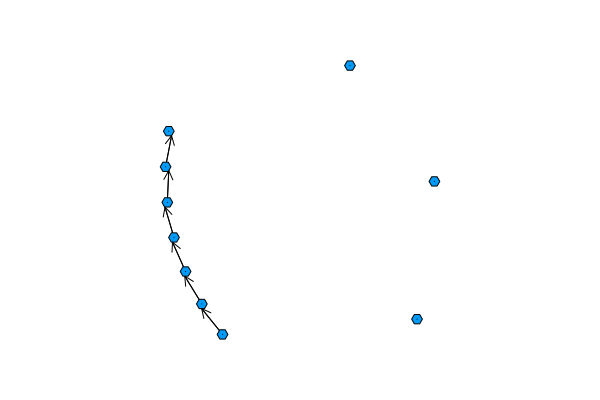

In [125]:
l = SimpleDiGraph(size)

for i in 1:size 
    for j in 1:size
        if q[i,j] == 1
            add_edge!(l, i, j)
        end
    end
end
graphplot(l, curves=false)